# Magnetometer Calibration Example

Magnetometer calibration is the process of estimating and correcting systematic errors in a three‑axis magnetometer. A typical magnetometer has nine calibration parameters that need to be characterized:

- Scale factors (3 gains)  
- Sensor offsets (3 biases)  
- Non‑orthogonality between axes (3 angles)  

so that raw sensor readings `B_raw` can be transformed into true magnetic field vectors via: B_true = A * (B_raw - O), where O is a (3x1) matrix of the offsets and A is a (3x3) matrix of derived from the gains and non-orthagonality.

This notebook details how to solve for these parameters using a scalar reference magnetometer (Merayo et al., 2000). In absence of a scalar magnetometer, the International Geophysical Reference Frame (IGRF). The reference magnetic field value can be accessed at https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml?useFullSite=true. 

Typically, this procedure is done by placing an uncalibrated magnetometer in a coil system and rotating the field at a constant magnitude to form a full sphere of measurements. A reference scalar magnetometer is used to transform the ellipsoidal uncalibrated magnetic field measurements into a spherical calibrated set of measurements. **In the absence of a coil system and reference scalar magnetometer, it is possible to calibrate using the magnitude of the IGRF values and rotate your magnetometer outside to measure a full sphere of magnetic field data.** It is critical to avoid magnetic contamination from cell phones, cars, or any other environmental noise. 







In [1]:
import matplotlib.pyplot as plt
import numpy as np

#### Here, we create simulated magnetic field data at a magnitude of 40,000 nT and apply arbitrary gains, offsets, and non-orthagonality angles

In [2]:
"Create Simulated Magnetic Field Data"
delta_deg = 15
theta = np.arange(0, 180 + delta_deg, delta_deg) * np.pi/180  # polar angle
phi   = np.arange(0, 360, delta_deg) * np.pi/180  # azimuthal angle
TH, PH = np.meshgrid(theta, phi, indexing='ij')

magnitude = 40000 # nT
x = magnitude * np.sin(TH) * np.cos(PH)
y = magnitude * np.sin(TH) * np.sin(PH)
z = magnitude * np.cos(TH)

Bx = x.ravel()
By = y.ravel()
Bz = z.ravel()
B = np.array([Bx, By, Bz])
B_ref = np.linalg.norm(B, axis=0)

In [3]:
"Define calibration parameters to create uncalibrated data"
gains = np.array([1.1, 0.95, 1.3]) # multiplication factor
offset = np.array([600, -1200, 450]) # nT offsets
angles = np.deg2rad(np.array([15, 4, 7])) # non-orthagonality angles in Degrees to Radians 

g1, g2, g3 = gains
phi, rho, lam = angles

A = np.array([
    [ gains[0], np.tan(phi)*gains[1], np.tan(rho)*gains[2]],
    [ 0.0, gains[1], np.tan(lam)*gains[2] ],
    [ 0.0, 0.0, gains[2] ]
]) # Calibration Matrix

A_inv = np.linalg.inv(A) # Decalibration Matrix

B_raw = A_inv@B + offset[:, np.newaxis] + np.random.normal(0,5, B.shape) # Add some random normal noise to simulate intrinsic measurement error

Text(0.5, 0, 'Bz [nT]')

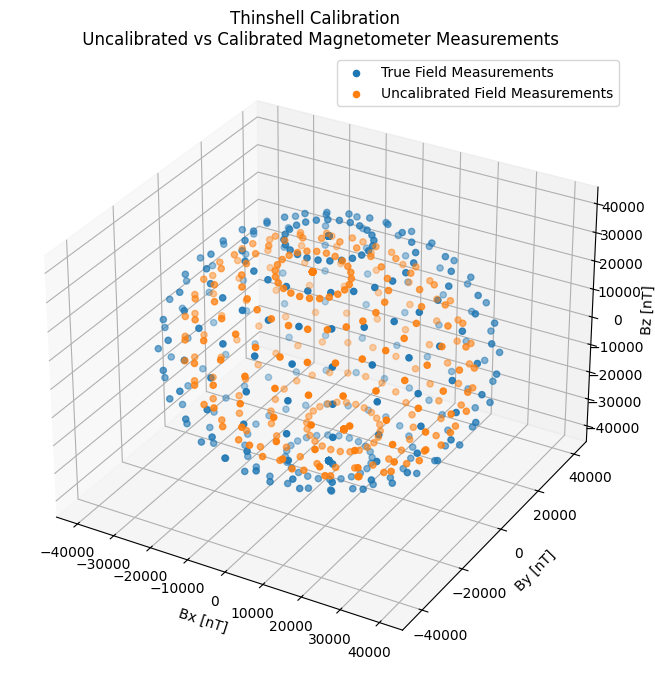

In [4]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (8,8))
ax.set_title("Thinshell Calibration \n Uncalibrated vs Calibrated Magnetometer Measurements")
ax.scatter(B[0], B[1], B[2], label ='True Field Measurements')
ax.scatter(B_raw[0], B_raw[1], B_raw[2], label = "Uncalibrated Field Measurements")
ax.legend()
ax.set_xlabel("Bx [nT]")
ax.set_ylabel("By [nT]")
ax.set_zlabel("Bz [nT]")

#### Apply Thinshell calibration

In [5]:
from magprime.calibration import thinshell

result = thinshell(B_raw[0], B_raw[1], B_raw[2], B_ref)
print("Calibration Parameters")
print("Offsets: ", result['O'])
print("Gains: ", result['gains'])
print('Angles: ', result['angles'])

"Calibrate magnetometer measurements"
B_calibrated = result['A']@(B_raw - result['O'][:, np.newaxis])

Calibration Parameters
Offsets:  [  600.29305028 -1199.30220086   450.19610987]
Gains:  [1.09997599 0.94998854 1.29998195]
Angles:  [14.99813049  3.99590532  6.99781234]


The residual should have the same STD as the random normal noise


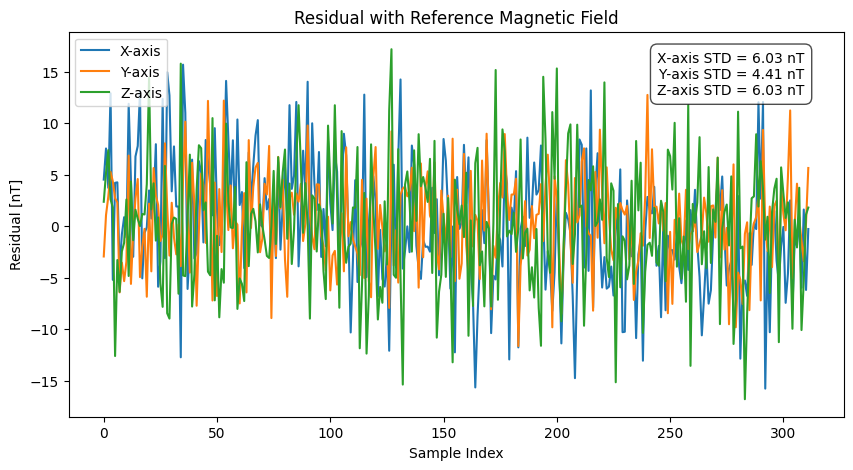

In [6]:
B_calibrated = result['A']@(B_raw - result['O'][:, np.newaxis])
std = np.std(B-B_calibrated, axis=1)
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(B[0] - B_calibrated[0], label = f'X-axis')
ax.plot(B[1] - B_calibrated[1], label = f'Y-axis')
ax.plot(B[2] - B_calibrated[2], label = f'Z-axis')
ax.legend(loc=2)
ax.set_title(f'Residual with Reference Magnetic Field')
ax.set_ylabel("Residual [nT]")
ax.set_xlabel("Sample Index")
textstr = '\n'.join([
    f"X‑axis STD = {std[0]:.2f} nT",
    f"Y‑axis STD = {std[1]:.2f} nT",
    f"Z‑axis STD = {std[2]:.2f} nT"
])
# box style
props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7)
ax.text(
    0.95, 0.95,           # x, y in axes fraction
    textstr,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=props
)
print("The residual should have the same STD as the random normal noise")